There are a few areas where this can be improved:
- Dealing with highly corealted features, like Age*Class and New_age
- Use a learning model to fit the missing Age Values, tried lienar regression and neural net(for practice) not much improvment but could have more succes with others
- the Fare value has a strong right skew, tried log transform but some 0's mess with transformation and not much improvment when I tried earlier
- Think of new features that could have some effect, also refine features with feature selection. 
- Have tried other models besides Random Forrest but they were inferior, more extensive hyper-param tuning could help increase model accuracy
- Look deeper into Outlier data points 
- Adjust threshold value using confusion matrix as basis for tuning
- Best score of .7751 classification accuracy,


In [1]:
'''Importing all relevant libraries and their functions and also 
defining the test and train set'''

import numpy as np
import pandas as pd

from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


In [2]:
'''Creating working data frames for manipulation'''
X_train = train.copy()
X_test = test.copy()
y_train = X_train.pop('Survived')

In [3]:
'''imputing None for Na values in cabin and the mean Value for Fare for groupedby Pclass, Parch, Sex, Sibsp'''
X_train['Embarked'].fillna('C',inplace=True)
X_test.loc[X_test.Fare.isnull(),['Fare']] =8.613629

In [4]:
def substring_in_string(long_string,substrings):
    # Function to search for a smaller substring in a larger string    
    for substring in substrings:
        if substring in long_string:
            return (substring) 
    return('none')

In [5]:
'''If one of these titles is in the name column, replace the value of the name with title'''
titles = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
X_train['Title'] = X_train['Name'].map(lambda x: substring_in_string(x,substrings = titles))
X_test['Title'] = X_test['Name'].map(lambda x: substring_in_string(x,substrings = titles))

In [6]:
def replace_title(x):  
    #Function to replace a given title with either Mrs, Mr. or Miss
    title=x['Title']
    if (title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']):
            return 'Mr'
    elif (title in ['Countess', 'Mme']):
            return 'Mrs'
    elif title in ['Mlle', 'Ms']:
            return 'Miss'
    elif title == 'Dr':
            if x['Sex'] == 'Male':
                return 'Mr'
            else:
                return 'Mrs'
    else:
            return title

In [7]:
'''Applying replace title function '''
X_train.Title = X_train.apply(replace_title,axis=1)
X_test.Title = X_test.apply(replace_title,axis=1)

In [8]:
'''Defining and applying cabin_filling function '''
def cabin_filling(x):
    # tries to return first letter of cabin if not then it will return none
    try:
        return x[0]
    except:
        return 'None'
    
X_train['Deck']=X_train['Cabin'].map(lambda x: cabin_filling(x))
X_test['Deck']=X_test['Cabin'].map(lambda x: cabin_filling(x))


In [9]:
'''Popping the columns that have either been cleaned or should not have impact on model '''
X_train.drop(['PassengerId',"Name","Ticket","Cabin"],axis=1,inplace=True)
X_test.drop(['PassengerId',"Name","Ticket","Cabin"],axis=1,inplace=True)

In [10]:
'''filling creating groupbys to ultimately replace missing age values'''
train_grouped = X_train.groupby(['Sex','Pclass','Parch','Title'])
test_grouped = X_test.groupby(['Sex','Pclass','Title'])
f = lambda x: x.fillna(x.median())

In [11]:
#creating filled in dataframe
train_trans = train_grouped.transform(f)
test_trans = test_grouped.transform(f)

In [12]:
#creating just a New_age value 
X_train['New_Age'] = train_trans['Age']
X_test['New_Age'] = test_trans['Age']

In [13]:
#Dropping old Age column 
X_train.drop('Age',axis=1,inplace=True)
X_test.drop('Age',axis=1,inplace=True)

In [14]:
#Creating Two new features, Family Size, and Age*Class column 
X_train['Family_size'] = X_train['SibSp'] + X_train['Parch'] 
X_test['Family_size'] = X_test['SibSp'] + X_test['Parch'] 

X_train['Age*Class']=X_train['New_Age']*X_train['Pclass']
X_test['Age*Class']=X_test['New_Age']*X_test['Pclass']

In [15]:
'''Defining all categorcal varibale for dummy implimentation '''
categorical_variables =['Sex','Deck','Embarked','Title']

In [16]:
#getting Dummies
X_train = pd.get_dummies(X_train,columns = categorical_variables)
X_test = pd.get_dummies(X_test,columns = categorical_variables)

In [17]:
# columns not in the test set but in training set
X_test['Embarked_Missing'] = 0
X_test['Deck_T']=0

In [18]:
#standardizing the values then creating the pipleine and grid search dictioanry
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestClassifier(n_estimators=1000))
n_est = list(range(100, 1000, 100))
max_feat= ['sqrt','log2']       
#param_grid = dict(randomforestclassifier__max_features = max_feat,
#                  randomforestclassifier__min_samples_leaf=min_samples,
#                  randomforestclassifier__n_estimators = n_est)
param_grid = dict(randomforestclassifier__n_estimators = n_est,randomforestclassifier__max_features = max_feat)

In [19]:
#fitting model
grid = GridSearchCV(pipeline,param_grid, cv=10,scoring = 'accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurit...tors=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900], 'randomforestclassifier__max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [20]:
grid.best_params_

{'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 500}

In [21]:
#best CV score
grid.best_score_

0.8204264870931538

In [22]:
#making sure that order of columns is same
cols = X_train.columns.tolist()
X_test = X_test[cols]

In [28]:
#Getting predicted values and writing to a file 
y_test_pred = grid.predict(X_test)

final = pd.DataFrame({'PassengerId':test.PassengerId,'Survived':y_test_pred }).set_index('PassengerId').to_csv('entry12.csv')

In [23]:
from sklearn.feature_selection import SelectFromModel

In [27]:
clf = RandomForestClassifier(n_estimators=500,max_features='log2')
clf = clf.fit(X_train,y_train)

In [28]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'],ascending = True,inplace=True)
features.set_index('feature',inplace = True)

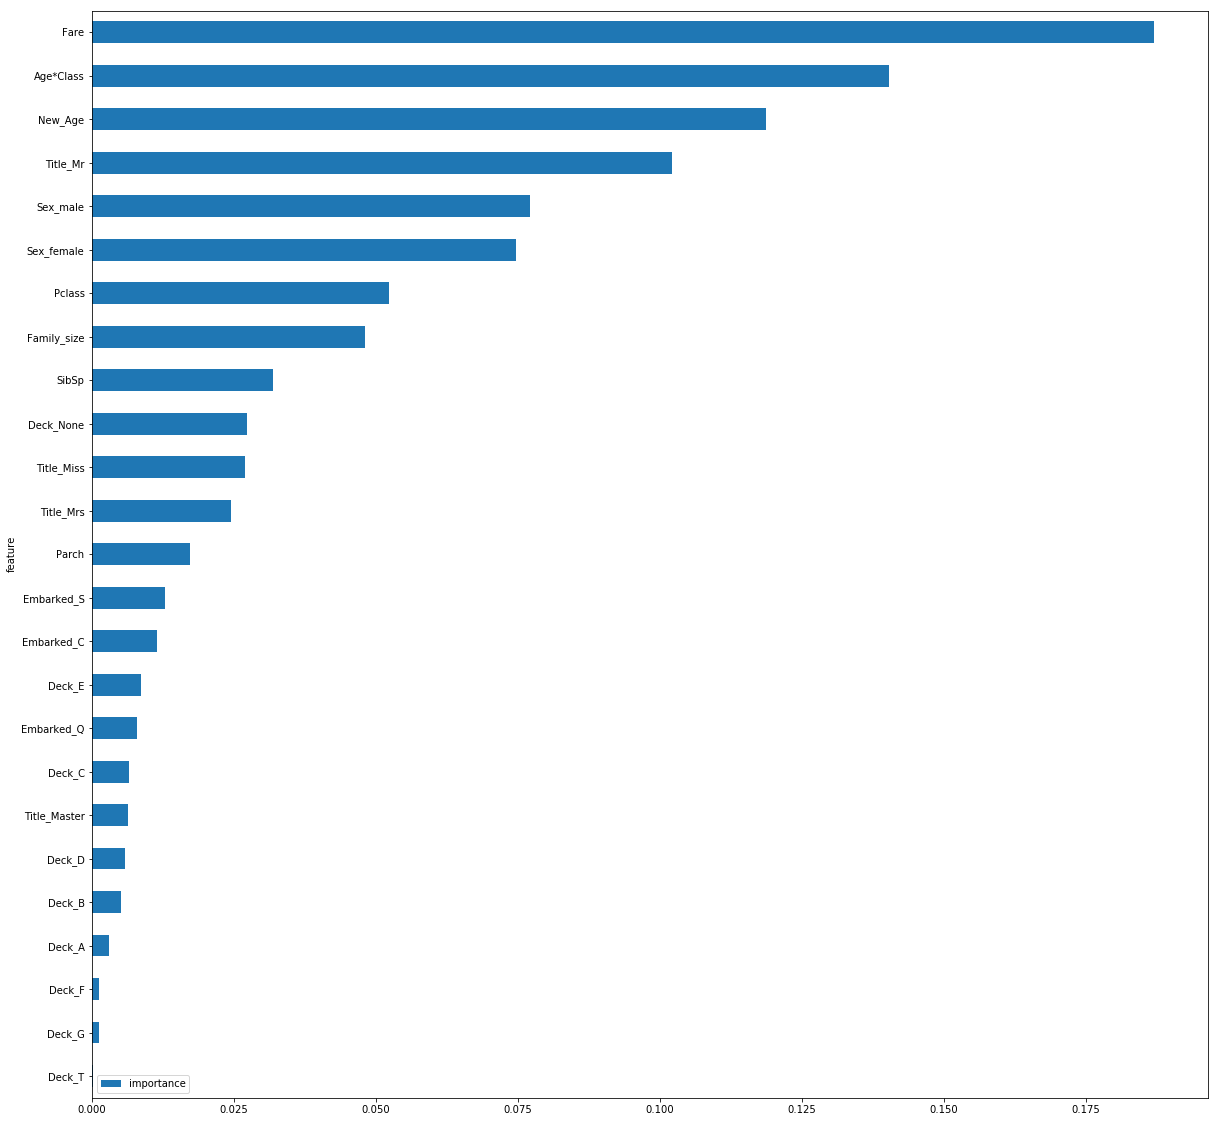

In [29]:
%matplotlib inline
features.plot(kind='barh',figsize =(20,20))